In [2]:
# Import necessary librariers
import numpy as np
import matplotlib.pyplot as plt
from simulation_configs import generateConfigurations
from simulation_modules import DisturbanceModule, ProcessModule, MeasurementModule, RegulatoryControlModule
import inspect
import pprint
import pandas as pd
import time as real_time

In [3]:
# Repeatable results
np.random.seed(85)

In [4]:
# Generate configurations
t, d, u, p, x, f, y, r, m, econ = generateConfigurations()

In [5]:
# Regularory control parameters
pprint.pprint(u)

{'PI': {'K': 0.1, 'tauI': 10},
 'control': True,
 'dt': 100,
 'intError': 0,
 'x0v': 0.5,
 'xFv': 0.5,
 'xWv': 0.5}


In [6]:
# Regulatory control module
print(inspect.getsource(RegulatoryControlModule))

def RegulatoryControlModule(u, y, r):
    # No regulatory control for F0 and F valves
    u['x0v'] = r['components']['valveF0']['position']
    u['xFv'] = r['components']['valveF']['position']

    # PI controller for FW valve
    # Check if controller mode is in automatic
    if r['components']['valveFW']['position'] == -1:
        # Calculate error
        error = r['setpoints']['C'] - y['C']['value']
        # Accumulate integral error
        u['intError'] = u['intError'] + error*u['dt']
        # Calculate controller output: output bias of zero?
        u['xWv'] = -u['PI']['K']*(error + u['intError']/u['PI']['tauI']) # TOASK: why no bias?
        # Note controller mode
        u['control'] = True
    else:
        # Manual control
        u['xWv'] = 0.5*r['components']['valveFW']['position'] # TOASK: why 0.5?
        u['intError'] = 0
        u['control'] = False

    return u



In [7]:
# Supervisory control configuration
pprint.pprint(r['components']['valveFW'])
pprint.pprint(r['setpoints'])

{'check_duration': 7200,
 'faultFlag': False,
 'position': -1,
 'replace_duration': 14400,
 'type': 'valve'}
{'C': 0.5}


In [8]:
# Generate disturbances
d_range = DisturbanceModule(d,t)

In [9]:
# Simulation
# Start timer for simulation duration
start_time = real_time.time()
# List of variables to save
results_list = ['Time (days)', 'V', 'uWv', 'xWv', 
                'L', 'F0', 'FW', 'F', 'C0','C', 'CSP',
                'F0m', 'FWm', 'Fm', 'C0m', 'Cm']
# Preallocate numpy array to store results
results = np.full((t['N'], len(results_list)),np.nan)
# Start simulation
print('Simulation progress:')
while t['tvector'][t['i']] < t['tmax']: # necessary while loop, since shuts can skip forward in time
    # Update time (check for jumps from maintenance)
    t['tvector'][t['i']+1] = t['tvector'][t['i']] + t['deltat']
    # Current disturbance
    d_now = {col: d_range[col][t['i']] for col in ['F0', 'C0']}
    
    # Regulatory control module
    u = RegulatoryControlModule(u, y, r)
    # Process module
    x = ProcessModule(p, u, d_now, x, f, t)
    # Measurement module
    y = MeasurementModule(y, x, d_now, f)
    # Update results
    results[t['i'], :] = [t['tvector'][t['i']]/(3600*24),
                          x['V'], 
                          u['xWv'],
                          x['xWv'], 
                          x['L'], 
                          x['F0'], 
                          x['FW'], 
                          x['F'], 
                          d_now['C0'], 
                          x['C'],
                          r['setpoints']['C'],
                          y['F0']['value'], 
                          y['FW']['value'], 
                          y['F']['value'], 
                          y['C0']['value'], 
                          y['C']['value']]
     # Display progress in percent time
    if t['tvector'][t['i']] % (2*24*3600) == 0:
        print(f'{t["tvector"][t["i"]]/t["tmax"]*100:.2f}%')
    # Update time index
    t['i'] += 1

# End timer for simulation duration
end_time = real_time.time()
# Print simulation duration
print(f'Done! Simulation duration: {end_time-start_time:.1f} seconds.')

Simulation progress:
0.00%
7.14%
14.29%
21.43%
28.57%
35.71%
42.86%
50.00%
57.14%
64.29%
71.43%
78.57%
85.71%
92.86%
Done! Simulation duration: 1.0 seconds.


In [10]:
# Convert results (numpy array) to DataFrame
df = pd.DataFrame(results, columns=results_list)
df.set_index('Time (days)', inplace=True)

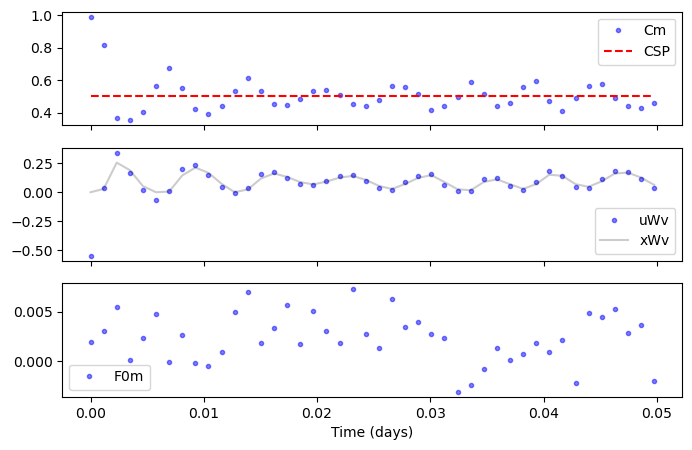

In [19]:
# Plot
startInd = 0
endInd = 0.05
plot_list = ['Cm','uWv','F0m']
axx=df[plot_list].loc[startInd:endInd].plot(subplots=True, color='blue',alpha=0.5,marker='.',ls='none',figsize=(8,5),legend=True)
axx[0].plot(df['CSP'].loc[startInd:endInd], 'r--',label='CSP')
axx[0].legend()
axx[1].plot(df['xWv'].loc[startInd:endInd], 'k-',alpha=0.2,label='xWv')
axx[1].legend()